In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append("../..") # add standard 's modules
# sys.path.append('/home/hbkoziel/pyfesom/codes/modules')
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

No joblib
no cmocean


In [2]:
# Loading mesh for run

mesh_id    = 'meshArc20'
meshpath   = '/scratch/usr/hbkvsk12/hlrn3_work2/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'VMIX'
first_year = 2014
last_year  = 2014
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc14'
months =np.linspace(0,9,10).astype(int)

/scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc20/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc20/pickle_mesh


In [3]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/'+runid+'/' # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'
plot_netcdf       = False                                         # Reads DIN from the created netcdf file, else it plots the interpolated field (should be the same)

In [4]:
# from derivative import derivative

# bafux_2d, bafuy_2d = derivative(mesh)
# f0 = 2*7.2921e-5 * np.sin(mesh.y2/180.*np.pi)

In [5]:
# ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
# f           = Dataset(ncfile, 'r')
# NodalVol = f.variables['cluster_vol'][:]
# f.close()
depth = mesh.zlevs
ind_max_depth = 18
depth[0:ind_max_depth]

array([ -0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       115., 135., 160., 190., 230., 280., 340.])

In [6]:
# np.diff(depth)
# mesh.n32[0,0:11]-1

# Extract 2D fields

In [7]:
for ind in range(0,len(years)):
    ncfile1       = input_directory+runid+'.'+str(years[ind])+'.oce.diag.nc'
    f1           = Dataset(ncfile1, 'r')
    ncfile2       = input_directory+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f2           = Dataset(ncfile2, 'r')
    netcdf_name = tracername+'.'+str(years[ind])+'.monthly.nc'
    
    print years[ind]
    # ==============================================================================
    # Loading data
#     print 'Loading data'
#     din       = f.variables['tr01'][:].mean(axis=0)
#     k     = f1.variables['Kv'][:].mean(axis=0)
    
    MIXN = np.zeros((len(months),len(mesh.x2)))
    print 'looping over months'
    for mo in months:
        print mo
        
        k    = f1.variables['Kv'][mo,:]
        din    = f2.variables['tr01'][mo,:]
   
        wDN_node = np.zeros(len(mesh.x2))
        print 'Looping over nodes'
        for i in range(0,len(mesh.x2)):
            #d_ind   = mesh.n32[i,0:11]-1
            #kkz = np.mean(k[d_ind[:-1]]) * np.diff(din[d_ind])/np.diff(depth[:11])
            #wDN_node[i] = np.mean(np.diff(kkz)/np.diff(depth[0:10]))
            d_ind   = mesh.n32[i,0:ind_max_depth]-1
            
            # parametrization #1 (not working)
            #kkz = np.diff(k[d_ind])/np.diff(depth[:ind_max_depth]) * np.diff(din[d_ind])/np.diff(depth[:ind_max_depth])
            
            # parametrization #2 (working)
            kkz = np.diff(k[d_ind]*din[d_ind])/np.diff(depth[:ind_max_depth])**2
            kkz[0] = 0
            
            # parametrization #3 (in test)
            #kkz = np.diff(k[d_ind[:-1]]*np.diff(din[d_ind]))/np.diff(depth[:ind_max_depth-1])**2
            
            wDN_node[i] = np.mean(np.abs(kkz))*24*3600/depth[ind_max_depth]
            #wDN_node[i] = np.trapz(np.abs(kkz), depth[:ind_max_depth-1])

        MIXN[mo,:] = wDN_node
        
    tracershape = np.shape(MIXN)

    # ==============================================================================
    # Testing if a netcdf file with the same name exists, if yes, it must be removed
    # to save a new one.

    if os.path.isfile(output_directory+netcdf_name) and delete_old_netcdf:
      os.remove(output_directory+netcdf_name)
      print "The netcdf file "+netcdf_name+" has been deleted to make room for your file of the same name."
    elif os.path.isfile(netcdf_name):
      statement = "The netcdf file "+netcdf_name+" already exists! It must be removed for a new one to be created. This can be done by changing your settings."
      sys.exit(statement)

    if not os.path.isdir(output_directory):
      os.makedirs(output_directory)
      print 'Directory '+output_directory+' has been created'

    # ==============================================================================
    # Creating netcdf file
    if save_netcdf:  
      import time
      w_nc_fid = Dataset(output_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
      w_nc_fid.description = u'VMIX' 
      w_nc_fid.history     = 'Created ' + time.ctime(time.time())

      nod2d    = w_nc_fid.createDimension('nod2d', mesh.n2d)               # Create dimension: number of 3d nodes
      time	   = w_nc_fid.createDimension('time', tracershape[0]) 

      w_nc_var = w_nc_fid.createVariable('VMIX', 'f4',('time','nod2d'))           # 'DIN' is name of saved variable/ 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'VMIX',\
                          'units': u'mmol/m2/day'})
      w_nc_fid.variables['VMIX'][:] = MIXN   
 
        
      w_nc_fid.close()                                                     # close the new file                

      cwd = os.getcwd()
      print "New netcdf file (",netcdf_name,") has been created."
      print "Location: "+output_directory
    else:
      print 'You have specified not to save your field in netcdf file'
    
#     # Loop over depths
#     for d in range(0,100+1,10):
#         ind_lev = np.max(np.argwhere(mesh.zlevs == d))
#         ind_depth = np.array(mesh.n32[:,ind_lev])

2014
looping over months
0
Looping over nodes
1
Looping over nodes
2
Looping over nodes
3
Looping over nodes
4
Looping over nodes
5
Looping over nodes
6
Looping over nodes
7
Looping over nodes
8
Looping over nodes
9
Looping over nodes
The netcdf file VMIX.2014.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VMIX.2014.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc14/netcdf_monthly/


In [8]:
# fig = plt.figure(figsize=(5, 5), facecolor='w', edgecolor='k')
# print np.mean(kkz)
# print np.mean(np.abs(kkz))
# plt.plot(kkz)
# plt.plot(np.abs(kkz))

# Interpolate to Arc12 mesh and save in binaries

In [9]:
from scipy.interpolate import griddata
mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkvsk12/hlrn3_work2/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh4 = pf.load_mesh(meshpath, usepickle=True, get3d=True)  
mixing_arc12_int = griddata((mesh.x2, mesh.y2), np.mean(MIXN,axis=0), (mesh4.x2, mesh4.y2), method='nearest') #nearest ?
np.save('VMIX2014_Arc12_yearly.npy', mixing_arc12_int)

/scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkvsk12/hlrn3_work2/mesh/meshArc4.5/pickle_mesh


In [10]:
mixing_arc12_int_monthly = np.empty((12,len(mesh4.x2)))
for i in np.arange(0,10):
    print i
    mixing_arc12_int_monthly[i,:] = griddata((mesh.x2, mesh.y2), MIXN[i,:], (mesh4.x2, mesh4.y2), method='nearest')
    
# faking the last couple missing months
mixing_arc12_int_monthly[10,:] = griddata((mesh.x2, mesh.y2), MIXN[0,:], (mesh4.x2, mesh4.y2), method='nearest')
mixing_arc12_int_monthly[11,:] = griddata((mesh.x2, mesh.y2), MIXN[0,:], (mesh4.x2, mesh4.y2), method='nearest')

np.save('VMIX2014_Arc12_monthly.npy', mixing_arc12_int_monthly)

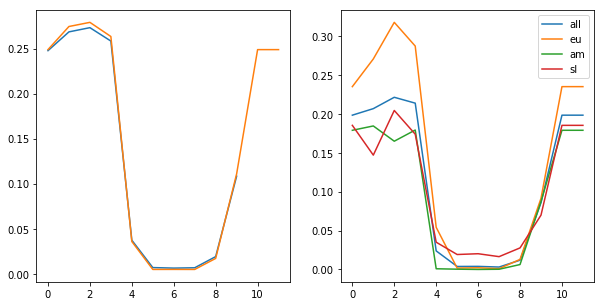

In [12]:
# Visual inspection
ind_all = np.load('index_all.npy')
ind_eu = np.load('index_eurasian.npy')
ind_am = np.load('index_amerasian.npy')
ind_sl = np.load('index_slope.npy')

fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k')
ax1      = fig.add_subplot(121)
y = np.mean(MIXN[:,mesh.y2>81],axis=1)
yy = np.mean(mixing_arc12_int_monthly[:,mesh4.y2>81],axis=1)
ax1.plot(y)
ax1.plot(yy)

ax2      = fig.add_subplot(122)
ax2.plot(np.mean(mixing_arc12_int_monthly[:,ind_all],axis=1),label='all')
ax2.plot(np.mean(mixing_arc12_int_monthly[:,ind_eu],axis=1),label='eu')
ax2.plot(np.mean(mixing_arc12_int_monthly[:,ind_am],axis=1),label='am')
ax2.plot(np.mean(mixing_arc12_int_monthly[:,ind_sl],axis=1),label='sl')
ax2.legend()

For depth 0 model level -0.0 will be used


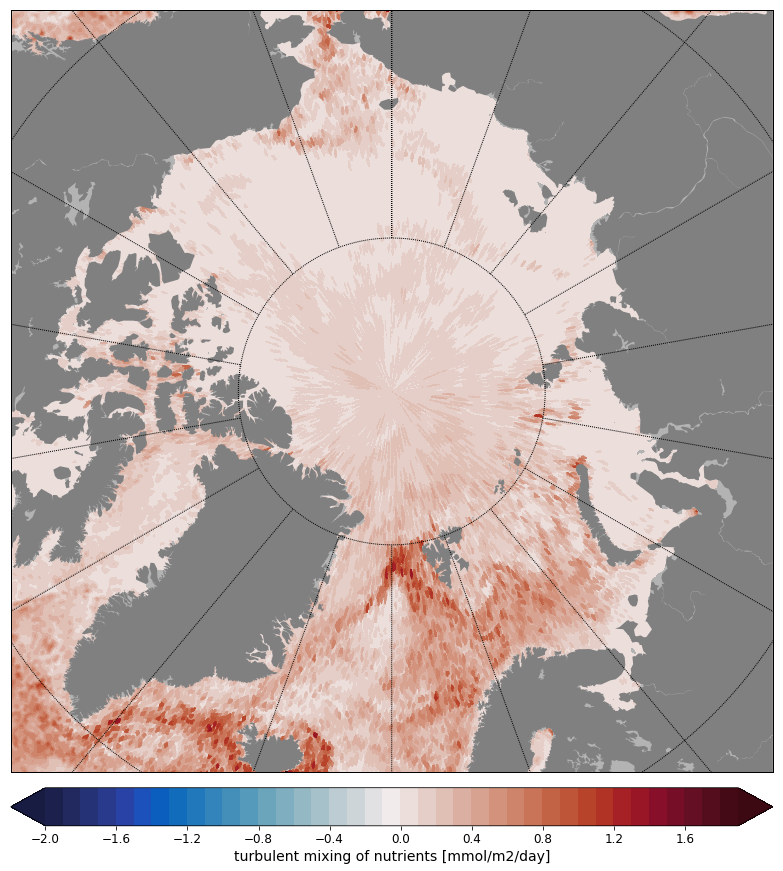

In [18]:
vmix = np.load('VMIX2014_Arc12_yearly.npy')

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
contours = np.arange(-2, 2, .1)

data, elem_no_nan = pf.get_data(vmix,mesh4,0)
ax1      = fig.add_subplot(111)
m = Basemap(projection='nplaea',boundinglat=65,lon_0=0,resolution='l')
x, y = m(mesh4.x2, mesh4.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'turbulent mixing of nutrients [mmol/m2/day]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Nutrient limitation', fontsize=16)

For depth 0 model level -0.0 will be used


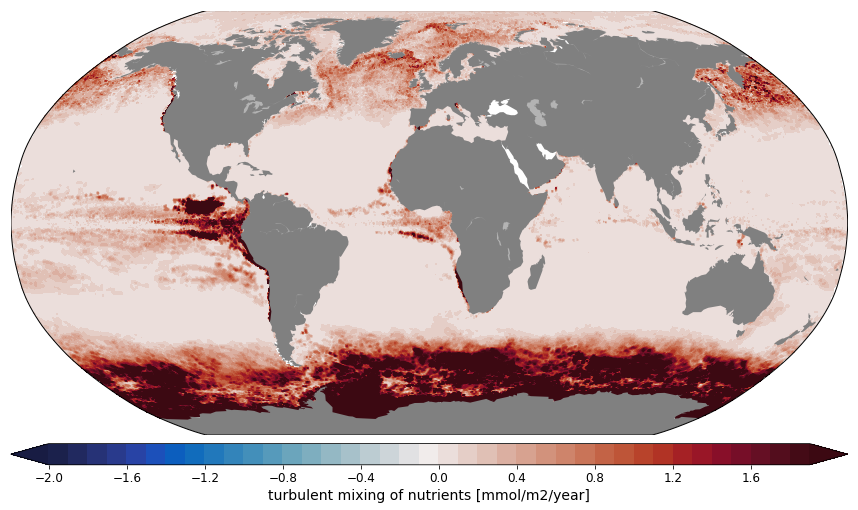

In [19]:
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

data, elem_no_nan = pf.get_data(vmix,mesh4,0)
ax1      = fig.add_subplot(111)
m = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = m(mesh4.x2, mesh4.y2)
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'turbulent mixing of nutrients [mmol/m2/year]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
#plt.title('Annual turbulent mixing of nutrients', fontsize=16)

# Extract vertical profiles

## Index for slope

In [20]:
ind1 = (np.array(mesh.topo > 300) & np.array(mesh.topo < 800))
ind2 = ~(np.array(mesh.y2 < 75) & np.array(np.abs(mesh.x2) < 80))
ind3 = ~(np.array(mesh.y2 < 66) & np.array(np.abs(mesh.x2) >= 80))
ind4 = ~(np.array(mesh.y2 < 80) & np.array(mesh.x2 < -20) & np.array(mesh.x2 > -100))
ind5 = ~(np.array(mesh.y2 < 80) & np.array(mesh.x2 > -20) & np.array(mesh.x2 < 0))
ind6 = ~(np.array(mesh.y2 < 80) & np.array(mesh.x2 > 20) & np.array(mesh.x2 < 60))

ind_bio1=ind1&ind2&ind3&ind4&ind5&ind6
ind_bio_slope = np.where(ind_bio1)
ind_bio_slope = np.squeeze(ind_bio_slope)
ind_bio_slope

array([ 47074,  47078,  47094, ..., 109149, 109152, 109153])

## Index eurasian basin

In [24]:
ind7 = (np.array(mesh.topo > 800) & np.array(mesh.y2 > 82) & np.array(mesh.x2 > -30) & np.array(mesh.x2 < 120))
ind_bio2 = ind7
ind_bio_eu = np.where(ind7)
ind_bio_eu = np.squeeze(ind_bio_eu)
#ind_bio_eu

## Index amerasian basin

In [22]:
ind8 = (np.array(mesh.topo > 800) & np.array(mesh.y2 > 73))
ind9 = ~(np.array(mesh.x2 > 0) & np.array(mesh.x2 < 150))
ind10 = ~(np.array(mesh.x2 < 0) & np.array(mesh.x2 > -90))
ind_bio3 = ind8&ind9&ind10
ind_bio_am = np.where(ind_bio3)
ind_bio_am = np.squeeze(ind_bio_am)

## index all

In [25]:
#ind_bio4=ind1&ind2&ind3&ind4&ind5&ind6&ind7&ind8&ind9&ind10
ind_bio4 = ind_bio1|ind_bio2|ind_bio3
ind_bio_all = np.where(ind_bio4)
ind_bio_all = np.squeeze(ind_bio_all)
ind_bio_all

array([ 47074,  47078,  47094, ..., 109149, 109152, 109153])

## Visual inspection of index

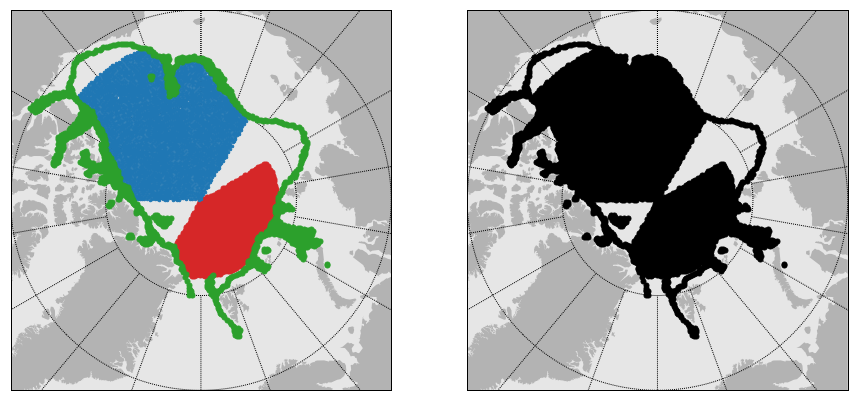

In [26]:
fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)


ax1      = fig.add_subplot(121)
map = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = map(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
map.drawparallels(np.arange(-80.,81.,10.), labels=plabels)
map.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
map.drawmapboundary(fill_color='0.9')
map.fillcontinents(color='.7',lake_color='.7')
plt.plot(x[ind_bio_eu], y[ind_bio_eu], '.', color = 'tab:red', markersize =10)
plt.plot(x[ind_bio_am], y[ind_bio_am], '.', color = 'tab:blue', markersize =5)
plt.plot(x[ind_bio_slope], y[ind_bio_slope], '.', color = 'tab:green', markersize =10)

ax2      = fig.add_subplot(122)
map = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = map(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
map.drawparallels(np.arange(-80.,81.,10.), labels=plabels)
map.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
map.drawmapboundary(fill_color='0.9')
map.fillcontinents(color='.7',lake_color='.7')
plt.plot(x[ind_bio_all], y[ind_bio_all], '.', color = 'k', markersize =10)

## Calculation

2014
looping over months
0
Looping over nodes
1
Looping over nodes
2
Looping over nodes
3
Looping over nodes
4
Looping over nodes
5
Looping over nodes
6
Looping over nodes
7
Looping over nodes
8
Looping over nodes
9
Looping over nodes
(18, 1316)
(10, 18)
0.178987199404783


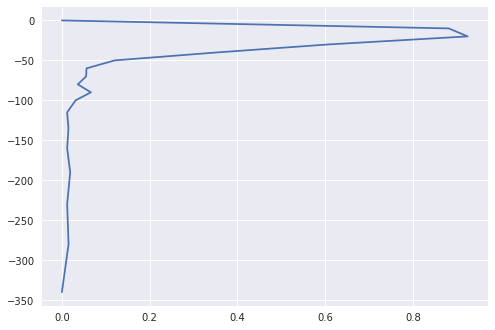

In [27]:
for ind in np.arange(0,1):
    ncfile1       = input_directory+runid+'.'+str(years[ind])+'.oce.diag.nc'
    f1           = Dataset(ncfile1, 'r')
    ncfile2       = input_directory+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f2           = Dataset(ncfile2, 'r')
    netcdf_name = tracername+'.'+str(years[ind])+'.monthly.nc'
    
    print years[ind]
    # ==============================================================================
    # Loading data
#     print 'Loading data'
#     din       = f.variables['tr01'][:].mean(axis=0)
#     k     = f1.variables['Kv'][:].mean(axis=0)
    
    MIXN = np.zeros((len(months),ind_max_depth))
    print 'looping over months'
    for mo in months:
        print mo
        
        k    = f1.variables['Kv'][mo,:]
        din    = f2.variables['tr01'][mo,:]
   
        wDN_node = np.zeros((ind_max_depth,len(ind_bio_slope)))
        print 'Looping over nodes'
        for i in range(0,len(ind_bio_slope)):
            d_ind   = mesh.n32[ind_bio_slope[i],0:ind_max_depth]-1
            yy = np.abs(np.diff(k[d_ind]*din[d_ind])/np.diff(depth[:ind_max_depth])**2)*24*3600/depth[ind_max_depth]
            yy[0] = 0
            wDN_node[:-1,i] = yy

        MIXN[mo,:] = np.mean(wDN_node,axis=1)
print np.shape(wDN_node)
print np.shape(MIXN)

np.save('VMIX2014_Arc12_profile_slope.npy', MIXN)

# visual inspection
plt.style.use('seaborn')
plt.plot(MIXN[0,:],-depth[:ind_max_depth])
print np.mean(MIXN[0,:])

2014
looping over months
0
Looping over nodes
1
Looping over nodes
2
Looping over nodes
3
Looping over nodes
4
Looping over nodes
5
Looping over nodes
6
Looping over nodes
7
Looping over nodes
8
Looping over nodes
9
Looping over nodes
(18, 6274)
(10, 18)


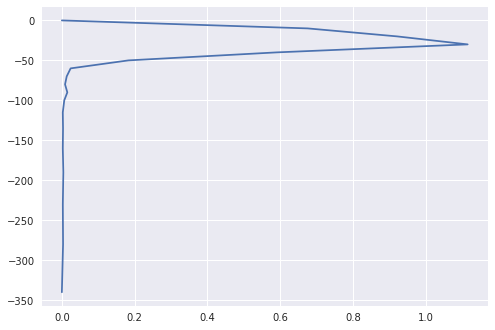

In [28]:
for ind in np.arange(0,1):
    ncfile1       = input_directory+runid+'.'+str(years[ind])+'.oce.diag.nc'
    f1           = Dataset(ncfile1, 'r')
    ncfile2       = input_directory+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f2           = Dataset(ncfile2, 'r')
    netcdf_name = tracername+'.'+str(years[ind])+'.monthly.nc'
    
    print years[ind]
    # ==============================================================================
    # Loading data
#     print 'Loading data'
#     din       = f.variables['tr01'][:].mean(axis=0)
#     k     = f1.variables['Kv'][:].mean(axis=0)
    
    MIXN = np.zeros((len(months),ind_max_depth))
    print 'looping over months'
    for mo in months:
        print mo
        
        k    = f1.variables['Kv'][mo,:]
        din    = f2.variables['tr01'][mo,:]
   
        wDN_node = np.zeros((ind_max_depth,len(ind_bio_all)))
        print 'Looping over nodes'
        for i in range(0,len(ind_bio_all)):
            d_ind   = mesh.n32[ind_bio_all[i],0:ind_max_depth]-1
            yy = np.abs(np.diff(k[d_ind]*din[d_ind])/np.diff(depth[:ind_max_depth])**2)*24*3600/depth[ind_max_depth]
            yy[0] = 0
            wDN_node[:-1,i] = yy

        MIXN[mo,:] = np.mean(wDN_node,axis=1)
print np.shape(wDN_node)
print np.shape(MIXN)

np.save('VMIX2014_Arc12_profile_all.npy', MIXN)

# visual inspection
plt.style.use('seaborn')
plt.plot(MIXN[0,:],-depth[:ind_max_depth])

2014
looping over months
0
Looping over nodes
1
Looping over nodes
2
Looping over nodes
3
Looping over nodes
4
Looping over nodes
5
Looping over nodes
6
Looping over nodes
7
Looping over nodes
8
Looping over nodes
9
Looping over nodes
(18, 3507)
(10, 18)


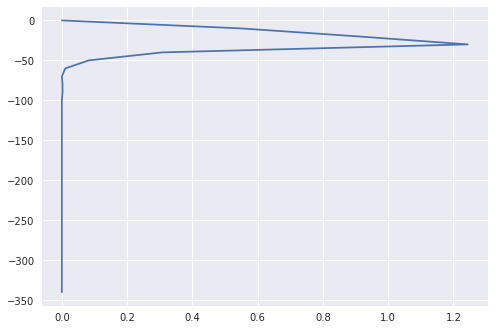

In [29]:
for ind in np.arange(0,1):
    ncfile1       = input_directory+runid+'.'+str(years[ind])+'.oce.diag.nc'
    f1           = Dataset(ncfile1, 'r')
    ncfile2       = input_directory+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f2           = Dataset(ncfile2, 'r')
    netcdf_name = tracername+'.'+str(years[ind])+'.monthly.nc'
    
    print years[ind]
    # ==============================================================================
    # Loading data
#     print 'Loading data'
#     din       = f.variables['tr01'][:].mean(axis=0)
#     k     = f1.variables['Kv'][:].mean(axis=0)
    
    MIXN = np.zeros((len(months),ind_max_depth))
    print 'looping over months'
    for mo in months:
        print mo
        
        k    = f1.variables['Kv'][mo,:]
        din    = f2.variables['tr01'][mo,:]
   
        wDN_node = np.zeros((ind_max_depth,len(ind_bio_am)))
        print 'Looping over nodes'
        for i in range(0,len(ind_bio_am)):
            d_ind   = mesh.n32[ind_bio_am[i],0:ind_max_depth]-1
            yy = np.abs(np.diff(k[d_ind]*din[d_ind])/np.diff(depth[:ind_max_depth])**2)*24*3600/depth[ind_max_depth]
            yy[0] = 0
            wDN_node[:-1,i] = yy

        MIXN[mo,:] = np.mean(wDN_node,axis=1)
print np.shape(wDN_node)
print np.shape(MIXN)

np.save('VMIX2014_Arc12_profile_am.npy', MIXN)

# visual inspection
plt.style.use('seaborn')
plt.plot(MIXN[0,:],-depth[:ind_max_depth])

2014
looping over months
0
Looping over nodes
1
Looping over nodes
2
Looping over nodes
3
Looping over nodes
4
Looping over nodes
5
Looping over nodes
6
Looping over nodes
7
Looping over nodes
8
Looping over nodes
9
Looping over nodes
(18, 1451)
(10, 18)


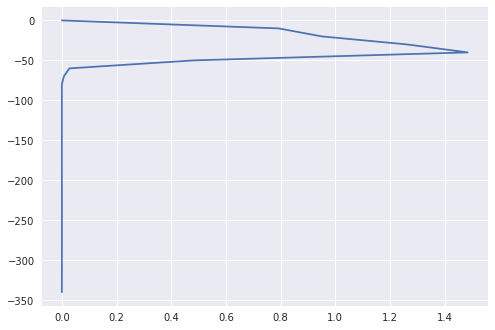

In [30]:
for ind in np.arange(0,1):
    ncfile1       = input_directory+runid+'.'+str(years[ind])+'.oce.diag.nc'
    f1           = Dataset(ncfile1, 'r')
    ncfile2       = input_directory+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f2           = Dataset(ncfile2, 'r')
    netcdf_name = tracername+'.'+str(years[ind])+'.monthly.nc'
    
    print years[ind]
    # ==============================================================================
    # Loading data
#     print 'Loading data'
#     din       = f.variables['tr01'][:].mean(axis=0)
#     k     = f1.variables['Kv'][:].mean(axis=0)
    
    MIXN = np.zeros((len(months),ind_max_depth))
    print 'looping over months'
    for mo in months:
        print mo
        
        k    = f1.variables['Kv'][mo,:]
        din    = f2.variables['tr01'][mo,:]
   
        wDN_node = np.zeros((ind_max_depth,len(ind_bio_eu)))
        print 'Looping over nodes'
        for i in range(0,len(ind_bio_eu)):
            d_ind   = mesh.n32[ind_bio_eu[i],0:ind_max_depth]-1
            yy = np.abs(np.diff(k[d_ind]*din[d_ind])/np.diff(depth[:ind_max_depth])**2)*24*3600/depth[ind_max_depth]
            yy[0] = 0
            wDN_node[:-1,i] = yy

        MIXN[mo,:] = np.mean(wDN_node,axis=1)
print np.shape(wDN_node)
print np.shape(MIXN)

np.save('VMIX2014_Arc12_profile_eu.npy', MIXN)

# visual inspection
plt.style.use('seaborn')
plt.plot(MIXN[0,:],-depth[:ind_max_depth])